First need to load the data in.

In [59]:
import pandas as pd

# --- URL of the SPF Individual CPI file ---
url = ("https://www.philadelphiafed.org/-/media/FRBP/Assets/"
       "Surveys-And-Data/survey-of-professional-forecasters/"
       "data-files/files/Individual_CPI.xlsx")

# --- Read directly from the web ---
df = pd.read_excel(url)

# --- Optional: inspect columns ---
print(df.columns)
print(df.head())

# --- Save as CSV ---
df.to_csv("SPF_Individual_CPI.csv", index=False)

print("CSV saved as SPF_Individual_CPI.csv")

Index(['YEAR', 'QUARTER', 'ID', 'INDUSTRY', 'CPI1', 'CPI2', 'CPI3', 'CPI4',
       'CPI5', 'CPI6', 'CPIA', 'CPIB', 'CPIC'],
      dtype='str')
   YEAR  QUARTER  ID  INDUSTRY  CPI1  CPI2  CPI3  CPI4  CPI5  CPI6  CPIA  \
0  1968        4   1       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  1968        4   2       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2  1968        4   3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3  1968        4   4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  1968        4   5       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   CPIB  CPIC  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN  
CSV saved as SPF_Individual_CPI.csv


/home/clayt/miniconda3/envs/ensemble/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Exploratory Data Analysis

This section inspects missingness, coverage over time, and how consistently individual forecasters report.


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path("SPF_Individual_CPI.csv")
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Fallback: download from the source URL defined above
    df = pd.read_excel(url)
    df.to_csv(data_path, index=False)

# Normalize blanks to NaN
df = df.replace(r"^\s*$", np.nan, regex=True)

# Cast core columns
df["YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce")
df["QUARTER"] = pd.to_numeric(df["QUARTER"], errors="coerce")
df["ID"] = pd.to_numeric(df["ID"], errors="coerce")

# Identify forecast columns
meta_cols = {"YEAR", "QUARTER", "ID", "INDUSTRY"}
forecast_cols = [c for c in df.columns if c not in meta_cols]

# Convert forecast columns to numeric
for c in forecast_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Basic cleaning
df = df.dropna(subset=["CPI1"])
df = df.sort_values(["YEAR", "QUARTER", "ID"]).reset_index(drop=True)

# Build a period column for time-series analysis (compatible with older pandas)
year_str = df["YEAR"].astype("Int64").astype(str)
qtr_str = df["QUARTER"].astype("Int64").astype(str)
period_str = year_str + "Q" + qtr_str
df["period"] = pd.PeriodIndex(period_str, freq="Q").to_timestamp("Q")

df


,YEAR,QUARTER,ID,INDUSTRY,CPI1,CPI2,CPI3,CPI4,CPI5,CPI6,CPIA,CPIB,CPIC,period
0,1981,3,4,NaN,9.1,8.9000,8.0000,7.6000,7.1000,6.9000,10.1000,7.9000,NaN,1981-09-30
1,1981,3,5,NaN,7.5,9.2000,8.2000,7.3000,7.6000,8.0000,4.9000,7.9000,NaN,1981-09-30
2,1981,3,16,NaN,7.5,9.2000,7.2000,6.5000,6.5000,6.5000,8.7000,6.5000,NaN,1981-09-30
3,1981,3,18,NaN,7.2,9.2000,6.9000,7.5000,8.2000,9.6000,7.4000,8.5000,NaN,1981-09-30
4,1981,3,19,NaN,7.5,11.2000,7.0000,6.5000,6.9000,6.2000,10.1000,7.2000,NaN,1981-09-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149,2025,4,602,1.0,3.1,3.2018,3.2514,2.6061,2.4334,2.2889,2.9477,2.6443,2.1828,2025-12-31
6150,2025,4,603,2.0,3.1,3.1381,2.4850,2.1465,2.0544,2.0792,2.9064,2.1911,1.9836,2025-12-31
6151,2025,4,607,2.0,3.1,2.9000,2.6000,2.4000,2.6000,2.7000,2.8500,2.5750,2.4000,2025-12-31
6152,2025,4,608,2.0,3.1,3.2000,3.1000,3.0000,2.9000,2.8000,2.9200,2.9500,2.8000,2025-12-31


In [61]:
# Missingness by horizon
missing_rate = df[forecast_cols].isna().mean().sort_values(ascending=False)
missing_rate


CPIC    0.592460
CPIB    0.069061
CPI6    0.027299
CPIA    0.017712
CPI5    0.005850
CPI2    0.002437
CPI4    0.002112
CPI3    0.002112
CPI1    0.000000
dtype: float64

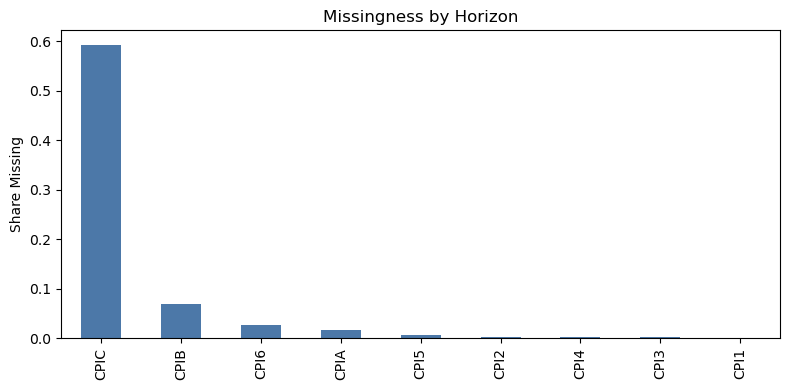

In [62]:
plt.figure(figsize=(8, 4))
missing_rate.plot(kind="bar", color="#4C78A8")
plt.ylabel("Share Missing")
plt.title("Missingness by Horizon")
plt.tight_layout()
plt.show()


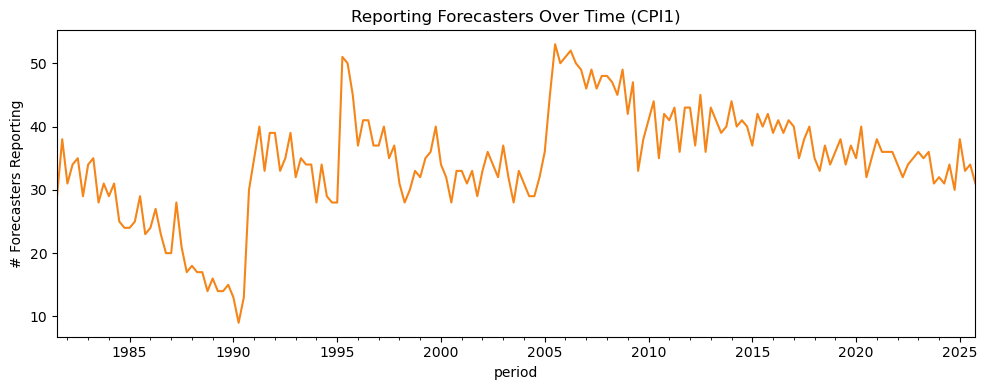

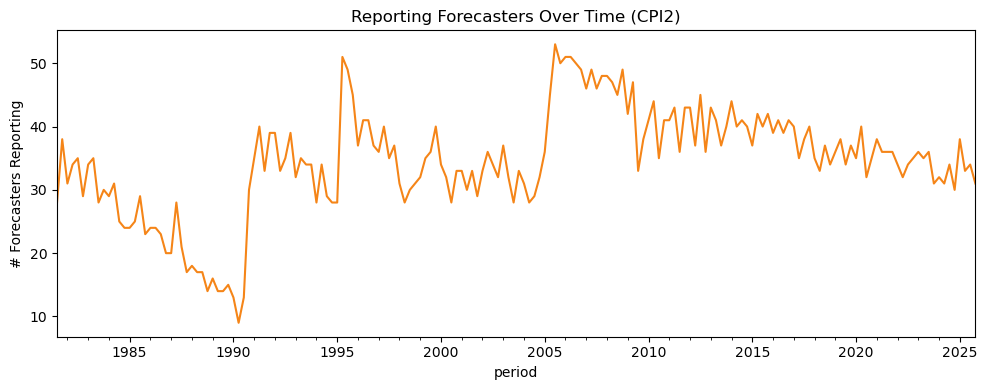

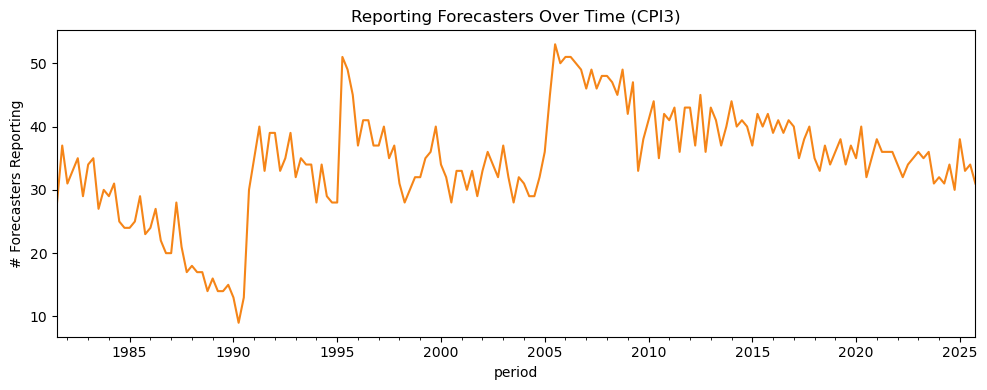

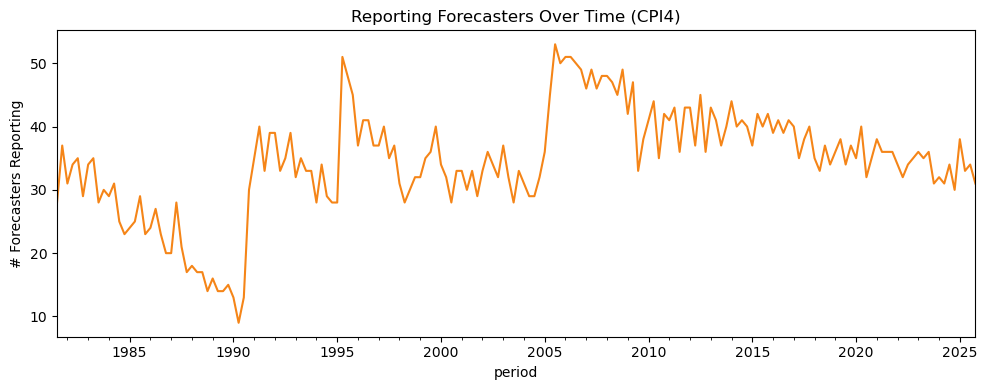

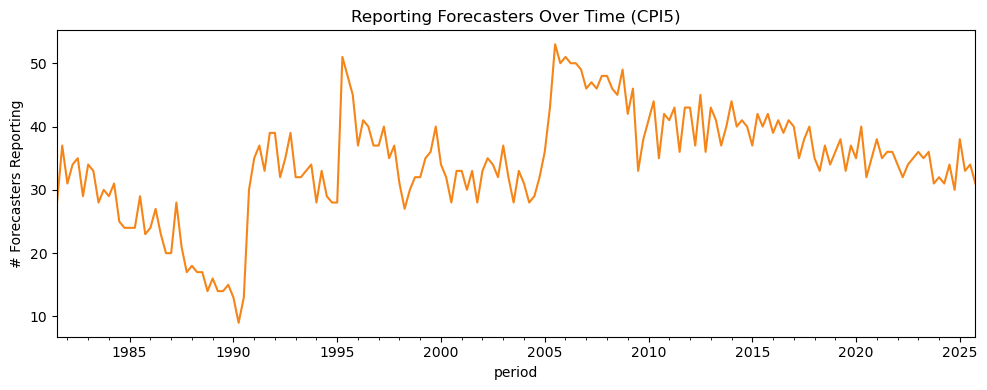

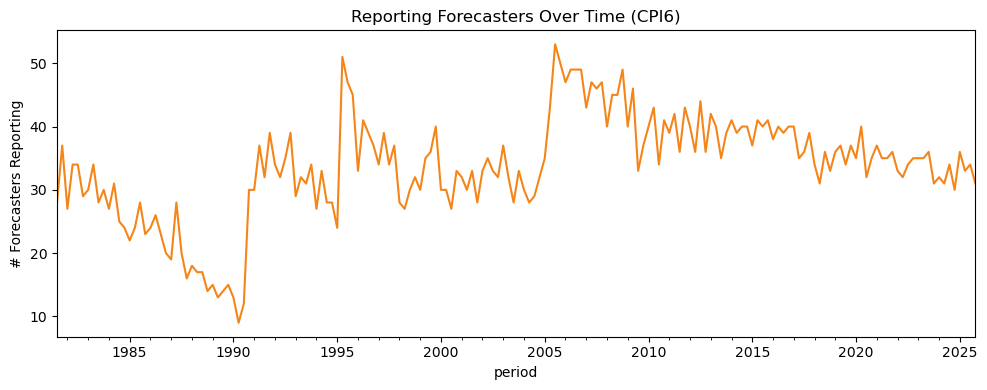

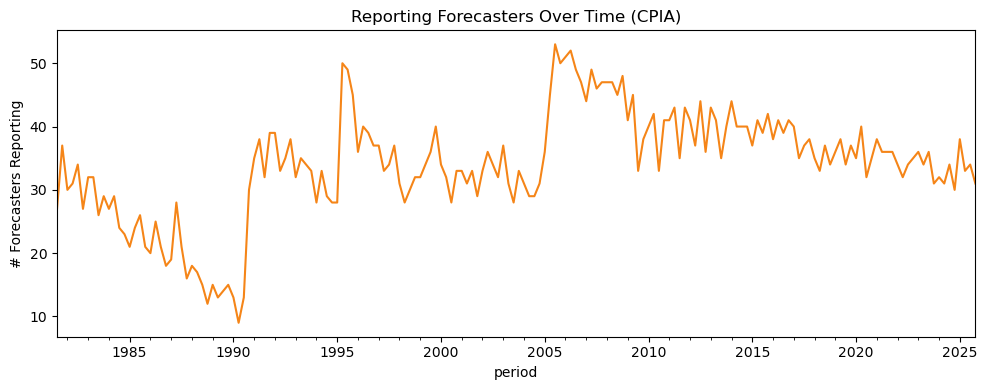

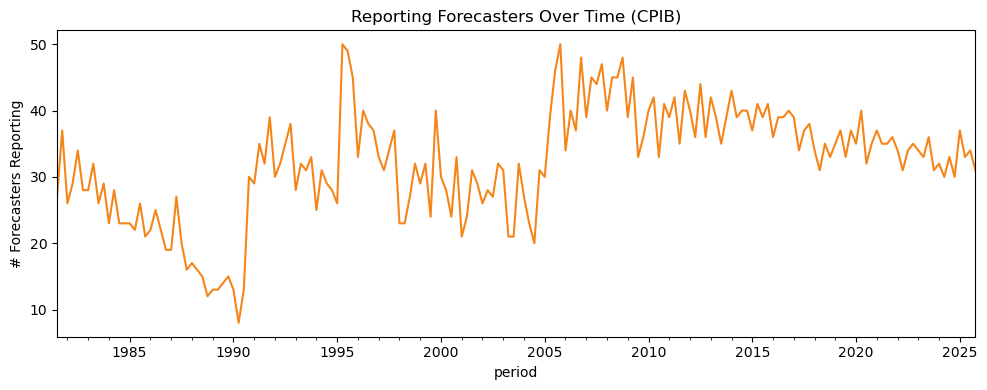

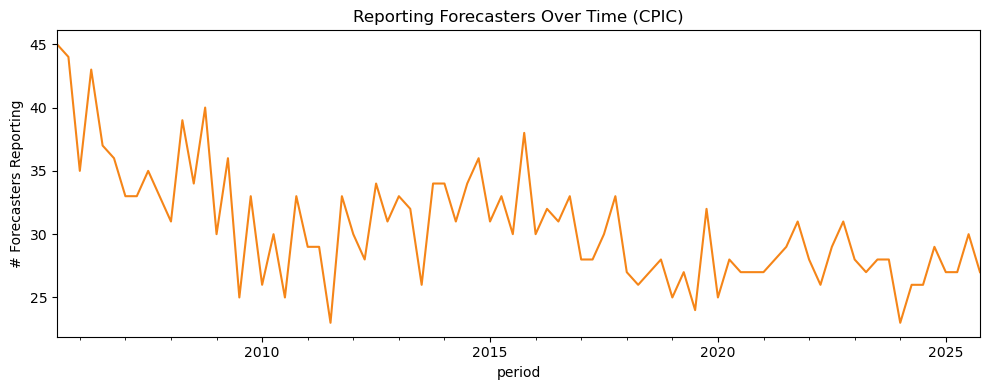

In [63]:
# Count of forecasters reporting per quarter, by horizon
for h in forecast_cols:
    forecasters_per_period = (
        df.loc[df[h].notna()]
          .groupby("period")["ID"]
          .nunique()
          .sort_index()
    )

    plt.figure(figsize=(10, 4))
    forecasters_per_period.plot(color="#F58518")
    plt.ylabel("# Forecasters Reporting")
    plt.title(f"Reporting Forecasters Over Time ({h})")
    plt.tight_layout()
    plt.show()


Horizon: CPI1
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


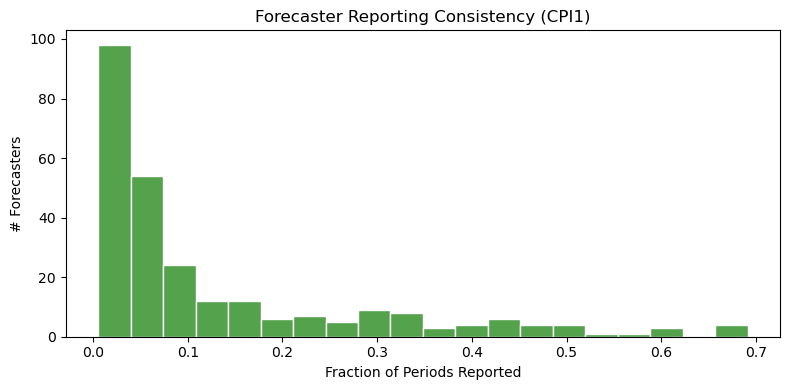

,report_fraction,report_count
ID,,
421,0.691011,123
433,0.691011,123
426,0.679775,121
411,0.668539,119
428,0.595506,106
463,0.595506,106
484,0.595506,106
510,0.578652,103
518,0.528090,94



Horizon: CPI2
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


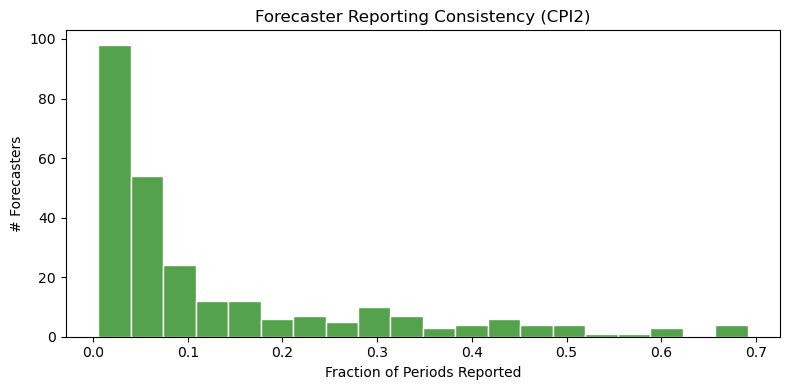

,report_fraction,report_count
ID,,
421,0.691011,123
433,0.691011,123
426,0.679775,121
411,0.668539,119
484,0.595506,106
463,0.595506,106
428,0.589888,105
510,0.573034,102
518,0.528090,94



Horizon: CPI3
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


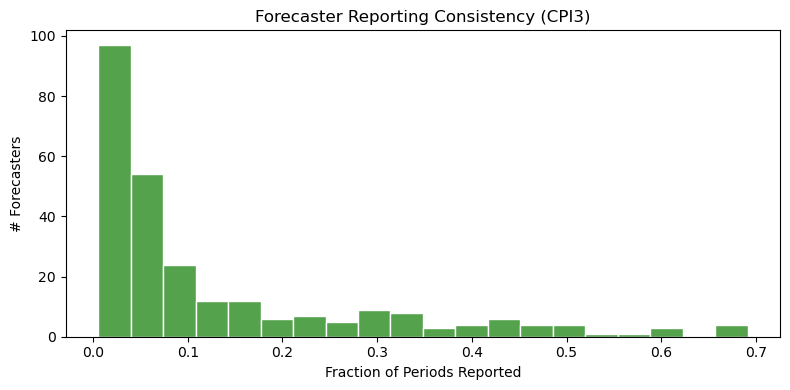

,report_fraction,report_count
ID,,
421,0.691011,123
433,0.691011,123
426,0.679775,121
411,0.668539,119
463,0.595506,106
484,0.595506,106
428,0.589888,105
510,0.573034,102
518,0.528090,94



Horizon: CPI4
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


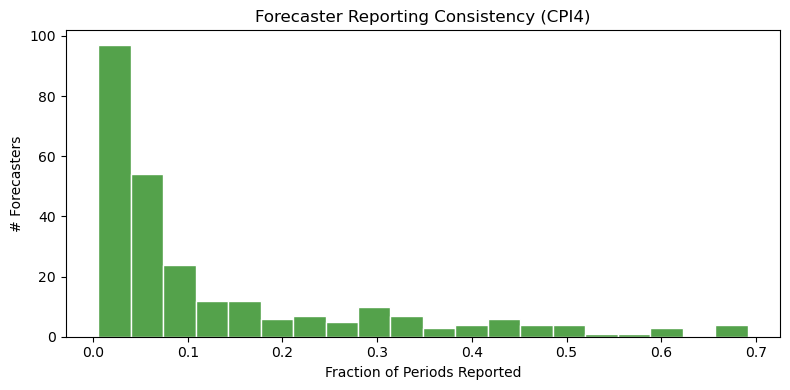

,report_fraction,report_count
ID,,
421,0.691011,123
433,0.691011,123
426,0.679775,121
411,0.668539,119
463,0.595506,106
484,0.595506,106
428,0.589888,105
510,0.573034,102
518,0.528090,94



Horizon: CPI5
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


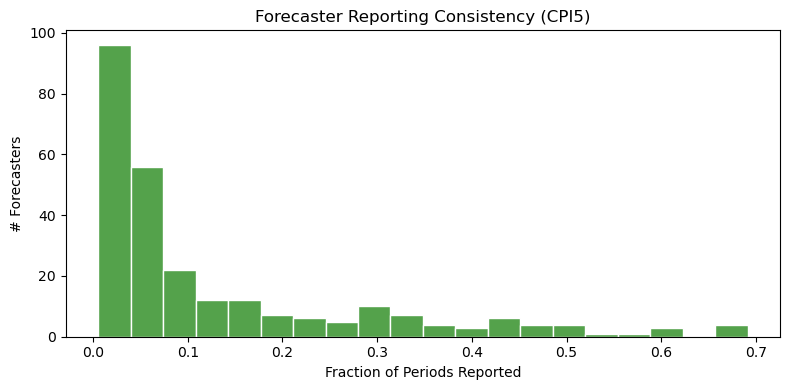

,report_fraction,report_count
ID,,
433,0.691011,123
421,0.691011,123
426,0.679775,121
411,0.668539,119
463,0.595506,106
484,0.595506,106
428,0.589888,105
510,0.573034,102
518,0.528090,94



Horizon: CPI6
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


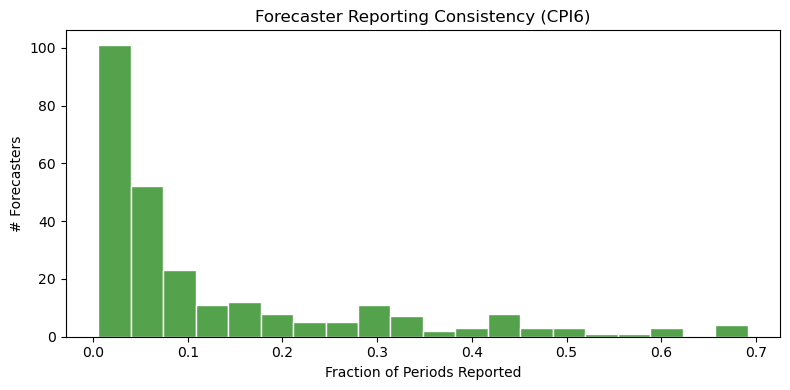

,report_fraction,report_count
ID,,
433,0.691011,123
421,0.691011,123
426,0.679775,121
411,0.668539,119
463,0.595506,106
428,0.589888,105
484,0.589888,105
510,0.573034,102
518,0.528090,94



Horizon: CPIA
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


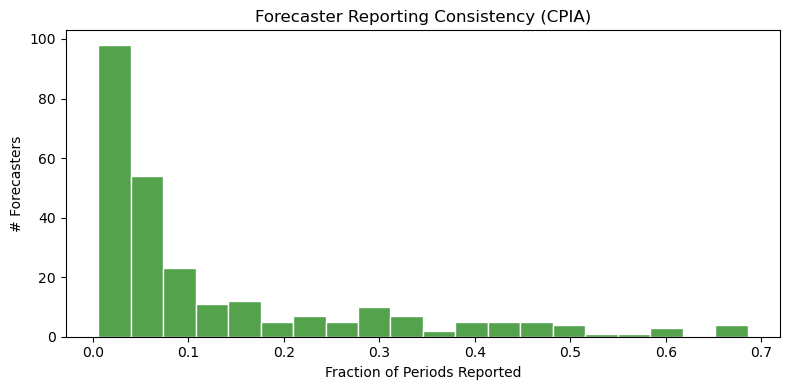

,report_fraction,report_count
ID,,
433,0.685393,122
421,0.685393,122
426,0.679775,121
411,0.662921,118
463,0.595506,106
484,0.589888,105
428,0.584270,104
510,0.578652,103
518,0.528090,94



Horizon: CPIB
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


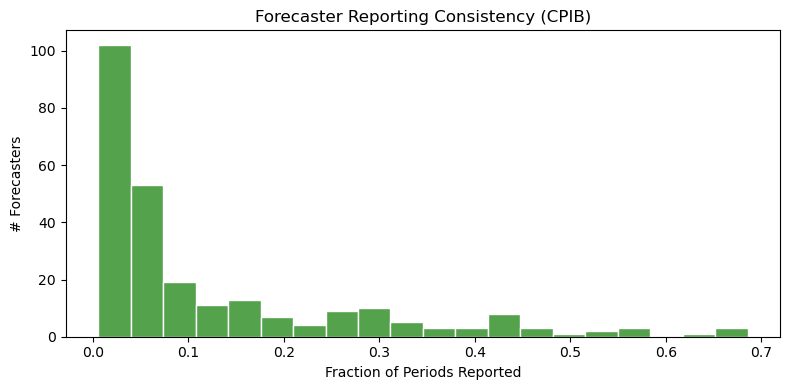

,report_fraction,report_count
ID,,
433,0.685393,122
426,0.662921,118
421,0.657303,117
411,0.646067,115
463,0.573034,102
428,0.561798,100
484,0.556180,99
510,0.533708,95
518,0.522472,93



Horizon: CPIC
  Total periods: 178
  Forecasters with 100% reporting: 0
  Forecasters with >=90% reporting: 0
  Forecasters with >=75% reporting: 0


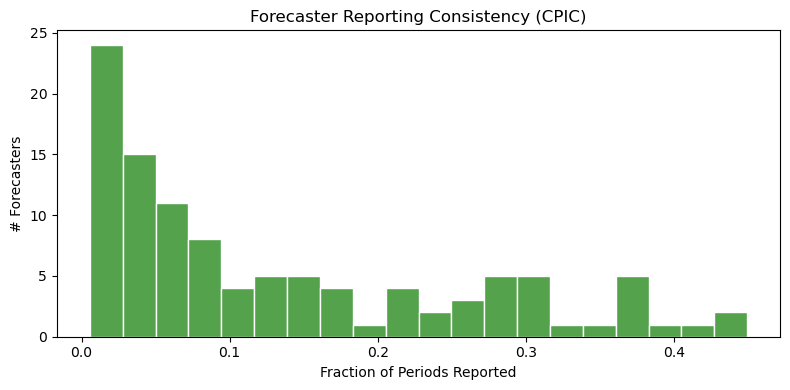

,report_fraction,report_count
ID,,
510,0.449438,80
518,0.443820,79
535,0.421348,75
411,0.387640,69
484,0.382022,68
504,0.370787,66
433,0.370787,66
463,0.370787,66
421,0.365169,65


In [64]:
# Consistency: fraction of periods in which each forecaster reports, by horizon
total_periods = df["period"].nunique()

for h in forecast_cols:
    report_counts = (
        df.loc[df[h].notna()]
          .groupby("ID")["period"]
          .nunique()
          .sort_values(ascending=False)
    )

    report_fraction = report_counts / total_periods

    print(f"Horizon: {h}")
    print(f"  Total periods: {total_periods}")
    print(f"  Forecasters with 100% reporting: {(report_fraction == 1).sum()}")
    print(f"  Forecasters with >=90% reporting: {(report_fraction >= 0.9).sum()}")
    print(f"  Forecasters with >=75% reporting: {(report_fraction >= 0.75).sum()}")

    # Distribution of reporting consistency
    plt.figure(figsize=(8, 4))
    plt.hist(report_fraction, bins=20, color="#54A24B", edgecolor="white")
    plt.xlabel("Fraction of Periods Reported")
    plt.ylabel("# Forecasters")
    plt.title(f"Forecaster Reporting Consistency ({h})")
    plt.tight_layout()
    plt.show()

    # Most consistent forecasters (top 10 by reporting fraction, then count)
    top_consistent = (
        pd.DataFrame({"report_fraction": report_fraction, "report_count": report_counts})
          .sort_values(["report_fraction", "report_count"], ascending=False)
          .head(10)
    )
    display(top_consistent)
    print()


Horizon: CPI1
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-09-30 00:00:00 (len=34 quarters)
    Fully reporting forecasters: 12
    IDs (n=12): [433, 504, 510, 518, 546, 549, 555, 563, 568, 570, 572, 574]


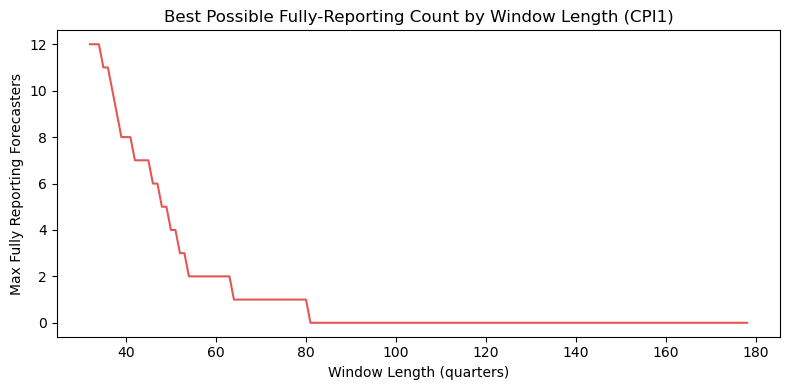


Horizon: CPI2
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-09-30 00:00:00 (len=34 quarters)
    Fully reporting forecasters: 12
    IDs (n=12): [433, 504, 510, 518, 546, 549, 555, 563, 568, 570, 572, 574]


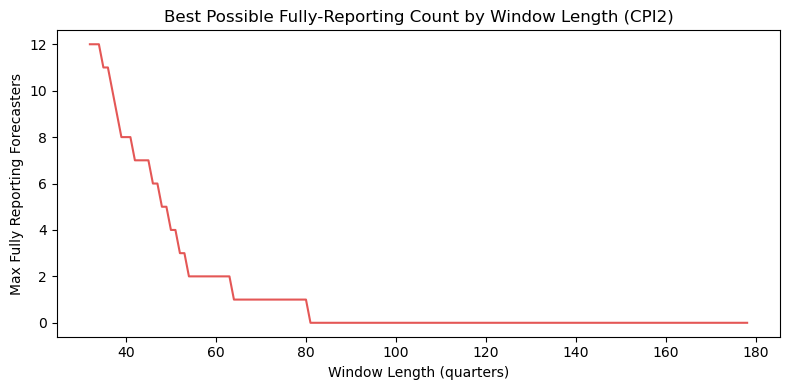


Horizon: CPI3
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-09-30 00:00:00 (len=34 quarters)
    Fully reporting forecasters: 12
    IDs (n=12): [433, 504, 510, 518, 546, 549, 555, 563, 568, 570, 572, 574]


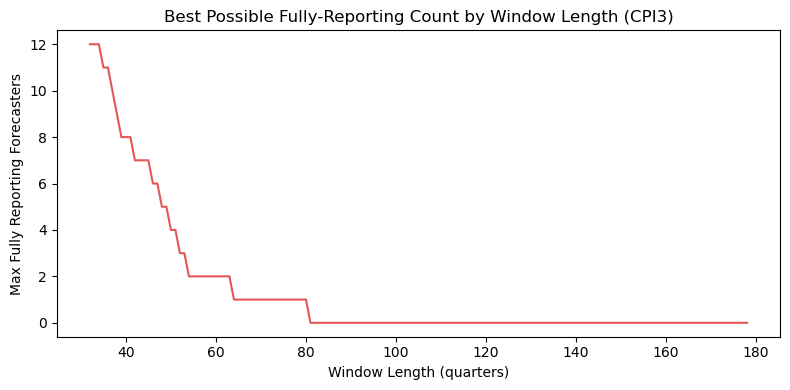


Horizon: CPI4
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-09-30 00:00:00 (len=34 quarters)
    Fully reporting forecasters: 12
    IDs (n=12): [433, 504, 510, 518, 546, 549, 555, 563, 568, 570, 572, 574]


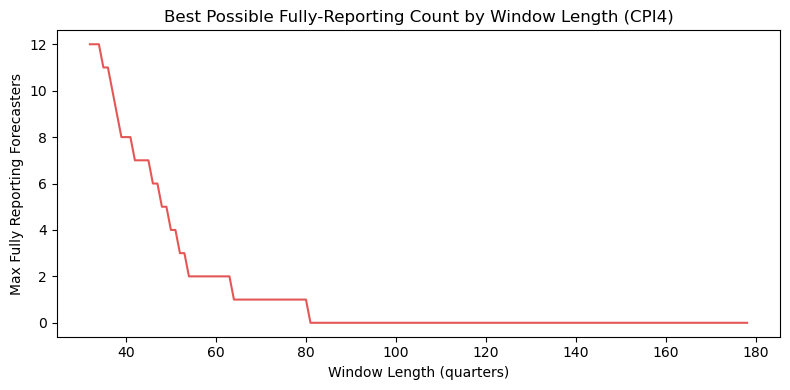


Horizon: CPI5
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-09-30 00:00:00 (len=34 quarters)
    Fully reporting forecasters: 11
    IDs (n=11): [433, 504, 510, 518, 546, 549, 563, 568, 570, 572, 574]


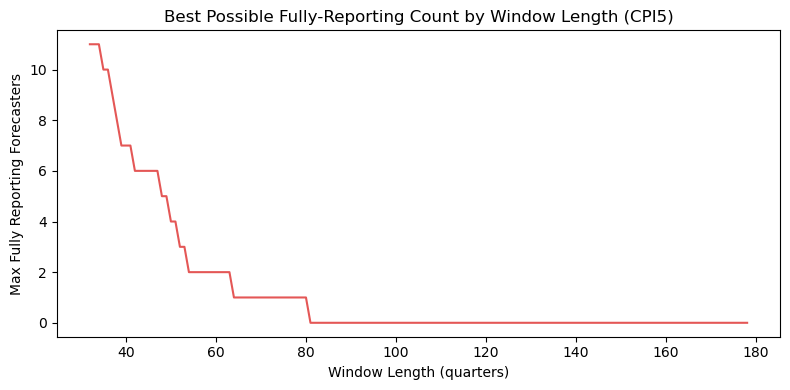


Horizon: CPI6
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-09-30 00:00:00 (len=34 quarters)
    Fully reporting forecasters: 11
    IDs (n=11): [433, 504, 510, 518, 546, 549, 555, 563, 568, 570, 572]


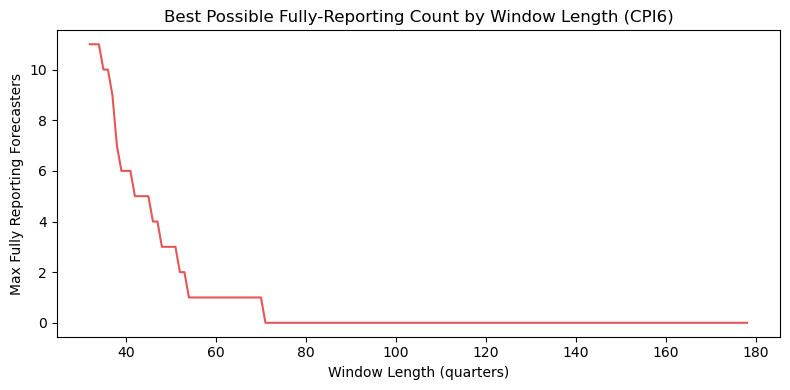


Horizon: CPIA
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-09-30 00:00:00 (len=34 quarters)
    Fully reporting forecasters: 12
    IDs (n=12): [433, 504, 510, 518, 546, 549, 555, 563, 568, 570, 572, 574]


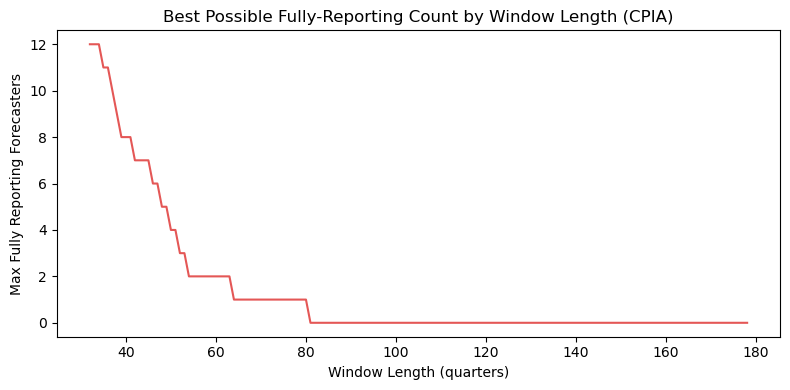


Horizon: CPIB
  Optimal window (max fully reporting forecasters):
    Window: 2013-12-31 00:00:00 to 2021-09-30 00:00:00 (len=32 quarters)
    Fully reporting forecasters: 11
    IDs (n=11): [433, 504, 510, 546, 549, 555, 557, 563, 570, 572, 574]


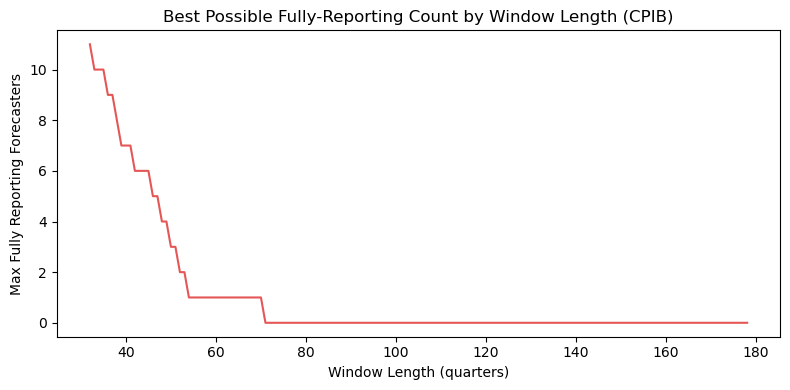


Horizon: CPIC
  Optimal window (max fully reporting forecasters):
    Window: 2014-06-30 00:00:00 to 2022-03-31 00:00:00 (len=32 quarters)
    Fully reporting forecasters: 9
    IDs (n=9): [433, 504, 510, 518, 549, 563, 570, 572, 574]


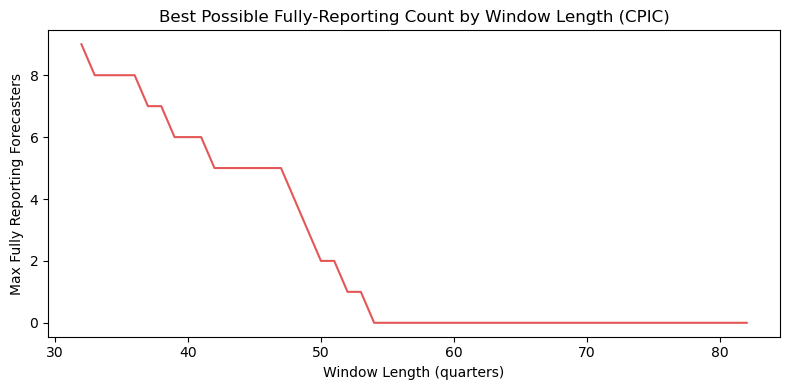

In [76]:
# Find the optimal contiguous period window maximizing fully-reporting forecasters, by horizon
# Definition: a forecaster is 'fully reporting' if they reported in every period within the window.
# Constraint: minimum window length of 15 years (60 quarters).
# Optional constraint: require the window to include a specific date (set REQUIRED_DATE).

MIN_YEARS = 8
MIN_WINDOW = MIN_YEARS * 4  # quarters
REQUIRED_DATE = None  # e.g., '2008-09-30' to require the window include 2008Q3

required_ts = pd.Timestamp(REQUIRED_DATE) if REQUIRED_DATE else None

for h in forecast_cols:
    report_pivot = (
        df.pivot_table(index="ID", columns="period", values=h, aggfunc="max")
          .notna()
          .astype(int)
    )
    report_pivot = report_pivot.sort_index(axis=1)

    periods = report_pivot.columns.to_list()
    values = report_pivot.to_numpy(dtype=int)  # shape: (n_forecasters, n_periods)

    n_periods = values.shape[1]
    best = None  # (count, start_idx, end_idx)
    max_by_window = []  # (window_len, max_count)

    for window_len in range(MIN_WINDOW, n_periods + 1):
        max_count = -1
        best_window = None
        for start in range(0, n_periods - window_len + 1):
            end = start + window_len
            # Optional requirement: window must include REQUIRED_DATE
            if required_ts is not None:
                if not (periods[start] <= required_ts <= periods[end - 1]):
                    continue

            # fully reporting if all ones in the window
            fully_reporting = (values[:, start:end] == 1).all(axis=1)
            count = int(fully_reporting.sum())
            if count > max_count:
                max_count = count
                best_window = (start, end)

        if best_window is None:
            continue

        max_by_window.append((window_len, max_count))
        if best is None or max_count > best[0] or (max_count == best[0] and window_len > (best[2] - best[1])):
            best = (max_count, best_window[0], best_window[1])

    if best is None:
        print(f"Horizon: {h}")
        print("  No window satisfies the constraints.")
        print()
        continue

    best_count, best_start, best_end = best
    best_start_period = periods[best_start]
    best_end_period = periods[best_end - 1]

    print(f"Horizon: {h}")
    print("  Optimal window (max fully reporting forecasters):")
    print(f"    Window: {best_start_period} to {best_end_period} (len={best_end - best_start} quarters)")
    print(f"    Fully reporting forecasters: {best_count}")

    # IDs of fully reporting forecasters in the optimal window
    optimal_fully_reporting = (values[:, best_start:best_end] == 1).all(axis=1)
    optimal_ids = report_pivot.index[optimal_fully_reporting].to_list()
    print(f"    IDs (n={len(optimal_ids)}): {optimal_ids}")

    # Plot: window length vs max fully reporting count
    window_lens = [w for w, c in max_by_window]
    max_counts = [c for w, c in max_by_window]
    plt.figure(figsize=(8, 4))
    plt.plot(window_lens, max_counts, color="#E45756")
    plt.xlabel("Window Length (quarters)")
    plt.ylabel("Max Fully Reporting Forecasters")
    plt.title(f"Best Possible Fully-Reporting Count by Window Length ({h})")
    plt.tight_layout()
    plt.show()
    print()


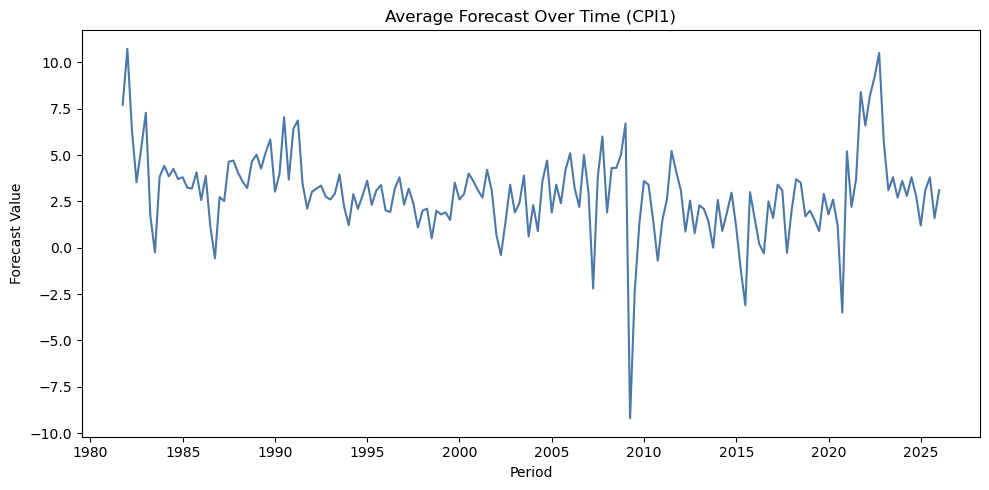

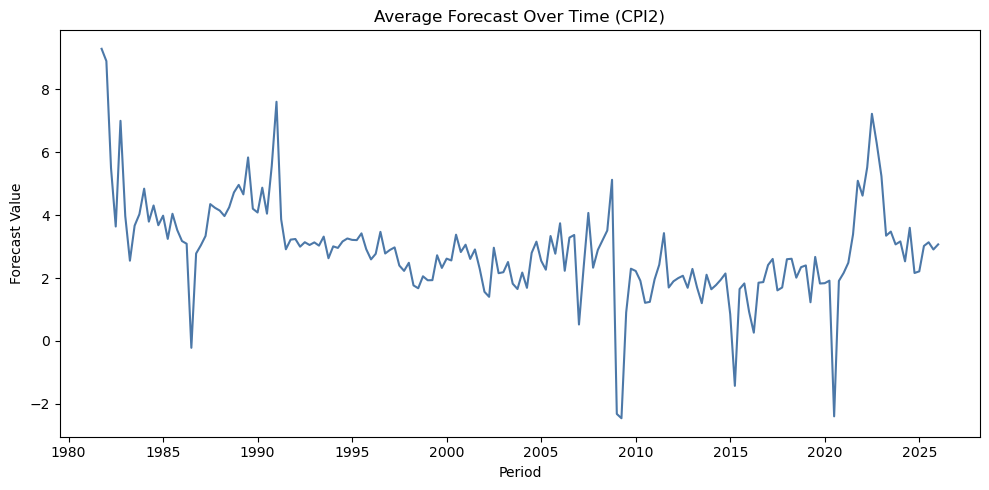

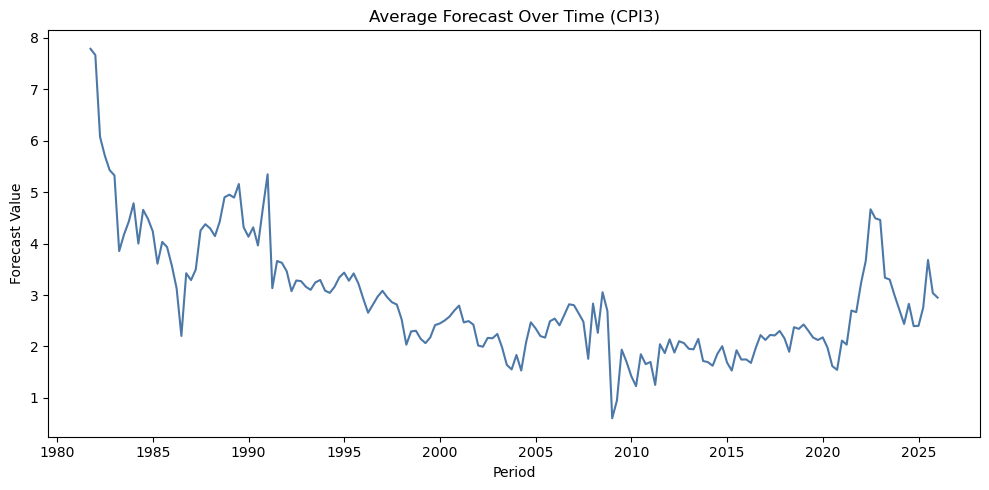

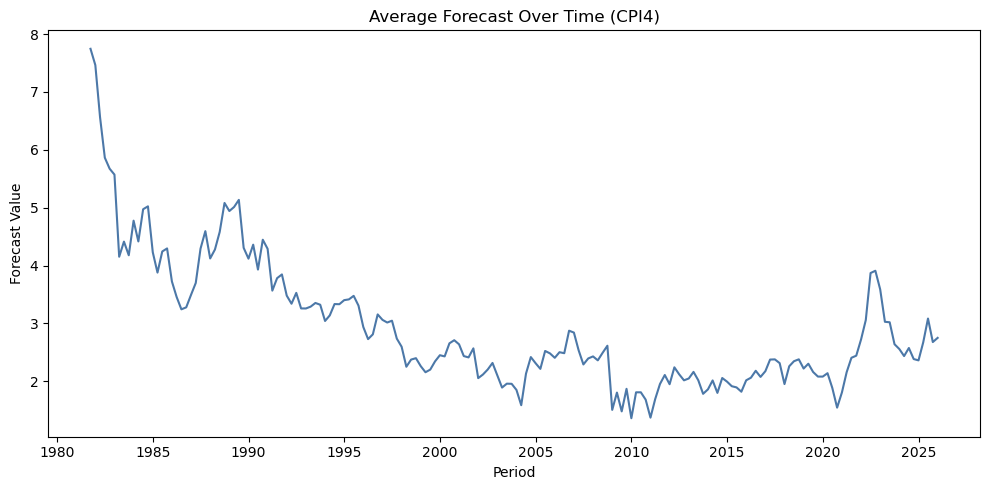

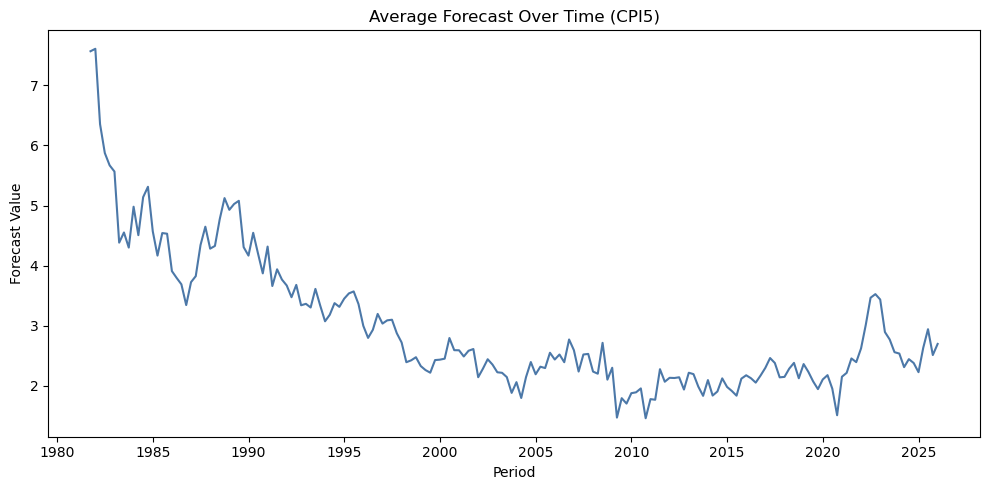

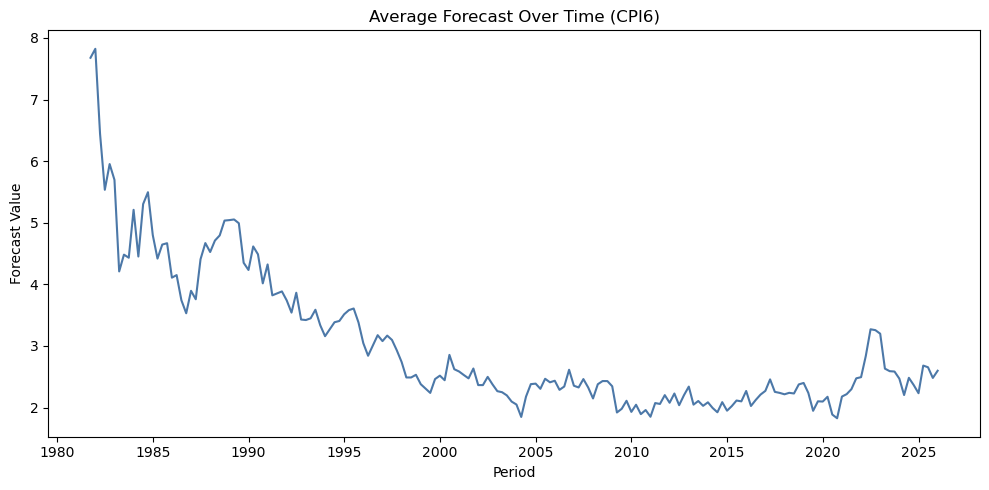

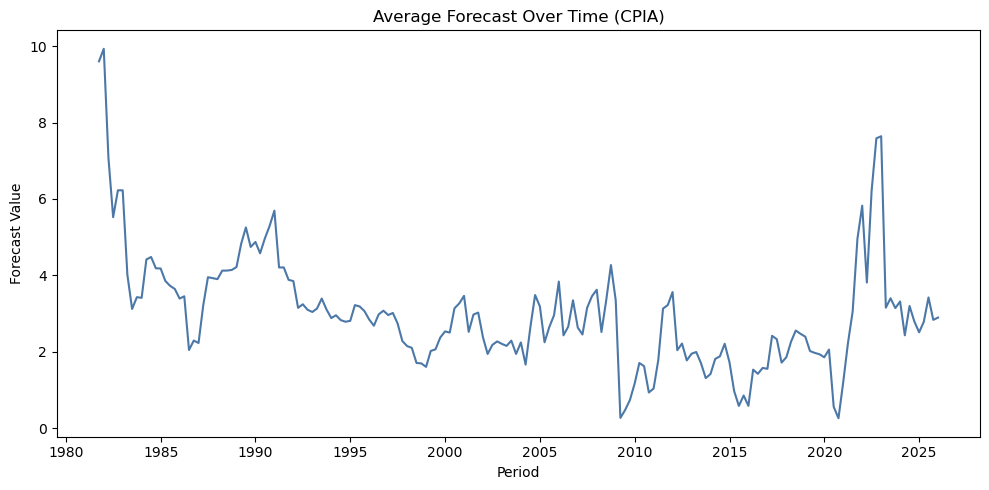

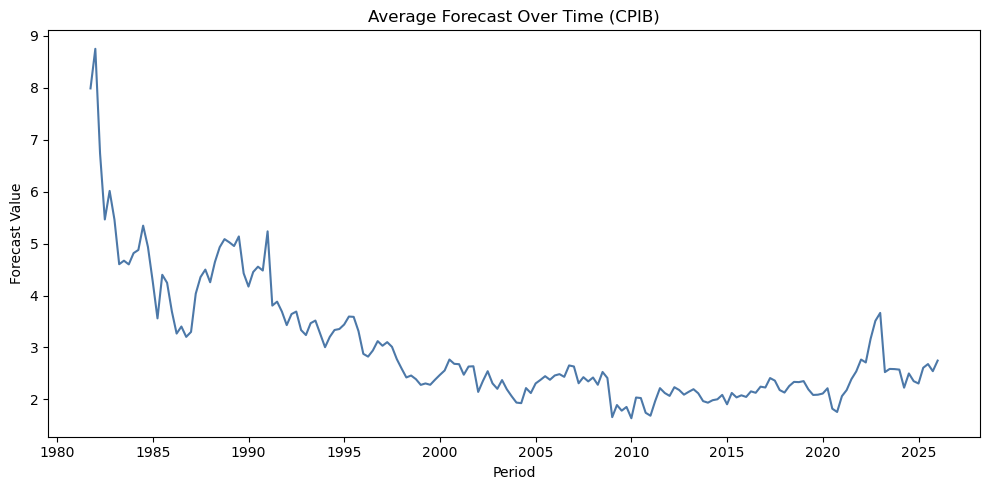

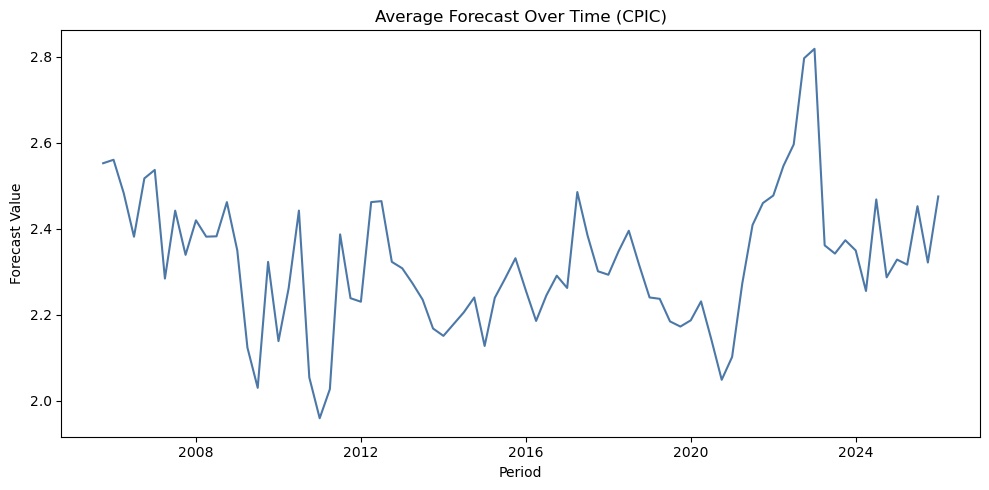

In [70]:
# Forecasts over time: average by horizon across forecasters (separate figures)
avg_by_period = df.groupby("period")[forecast_cols].mean().sort_index()

for h in forecast_cols:
    plt.figure(figsize=(10, 5))
    plt.plot(avg_by_period.index, avg_by_period[h], label=h, color="#4C78A8")
    plt.title(f"Average Forecast Over Time ({h})")
    plt.ylabel("Forecast Value")
    plt.xlabel("Period")
    plt.tight_layout()
    plt.show()


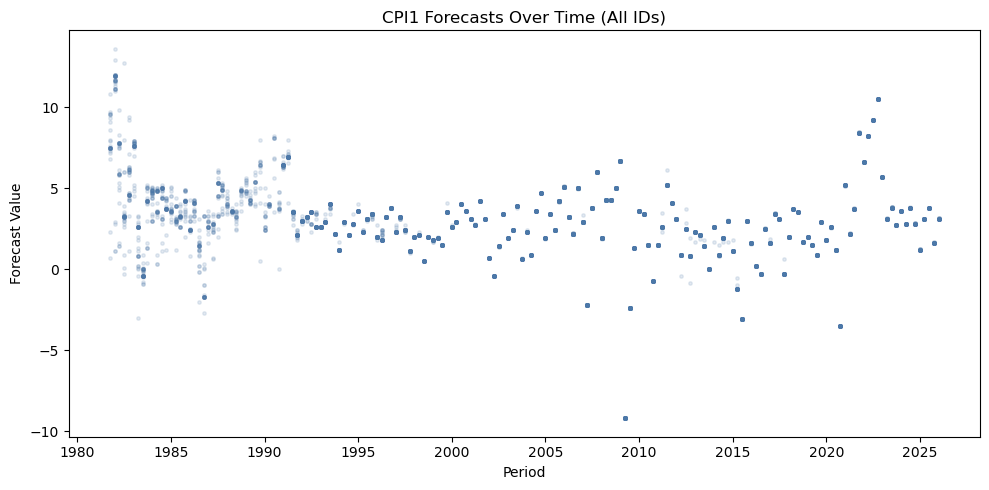

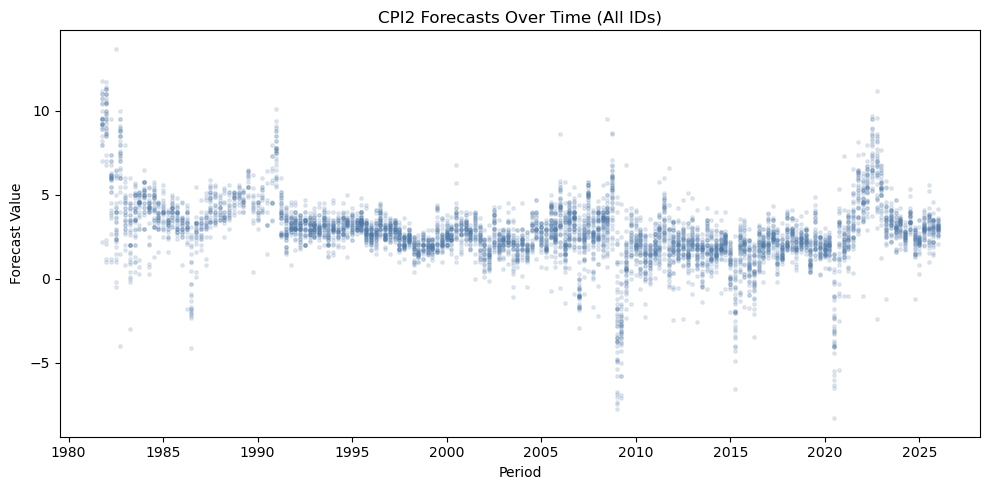

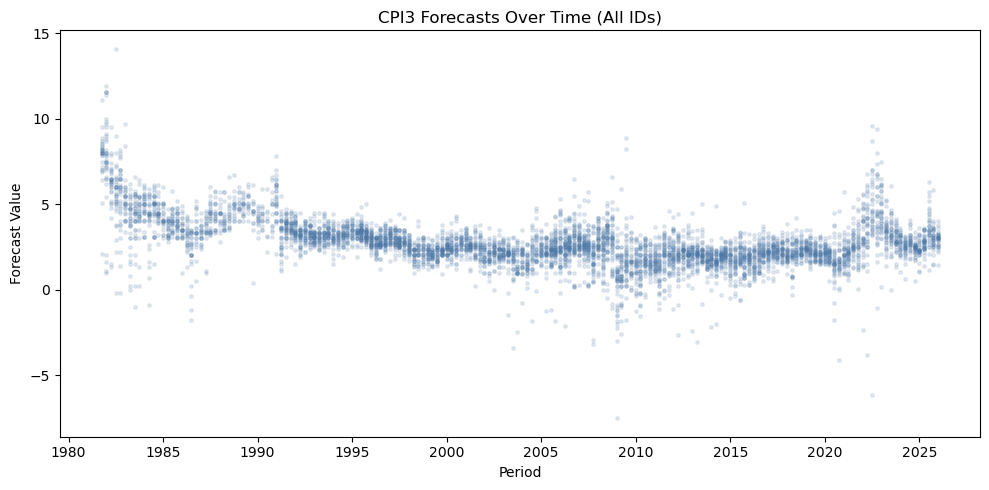

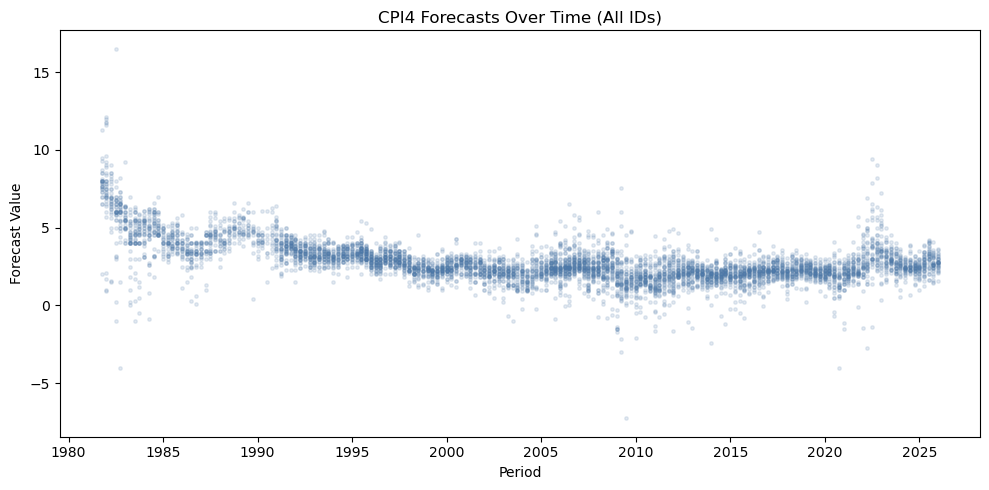

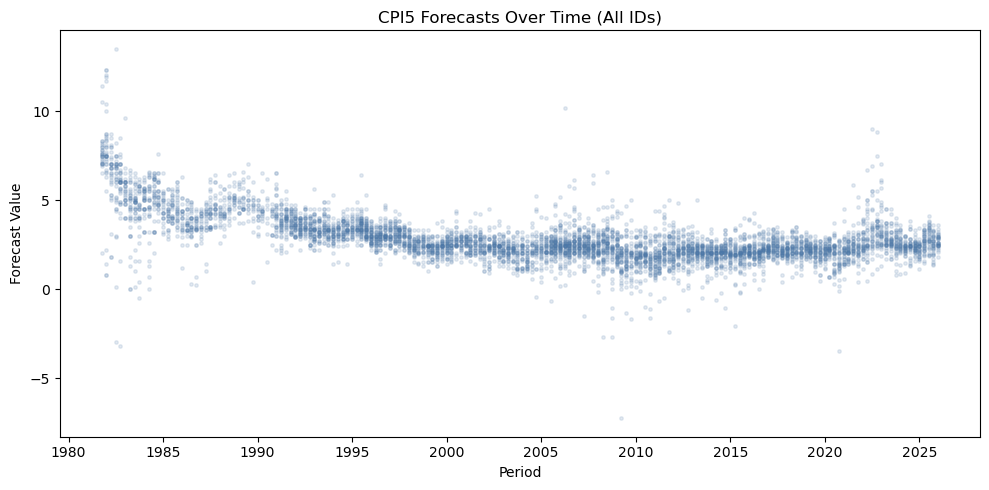

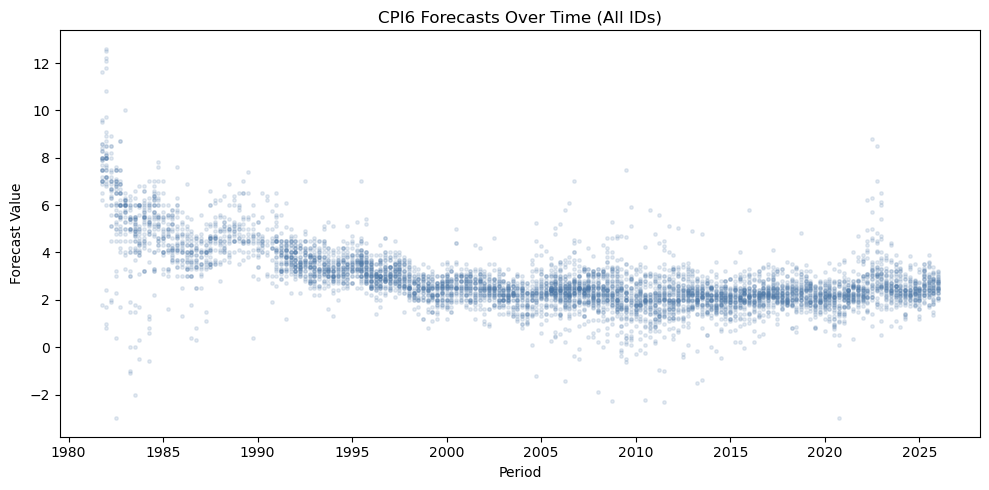

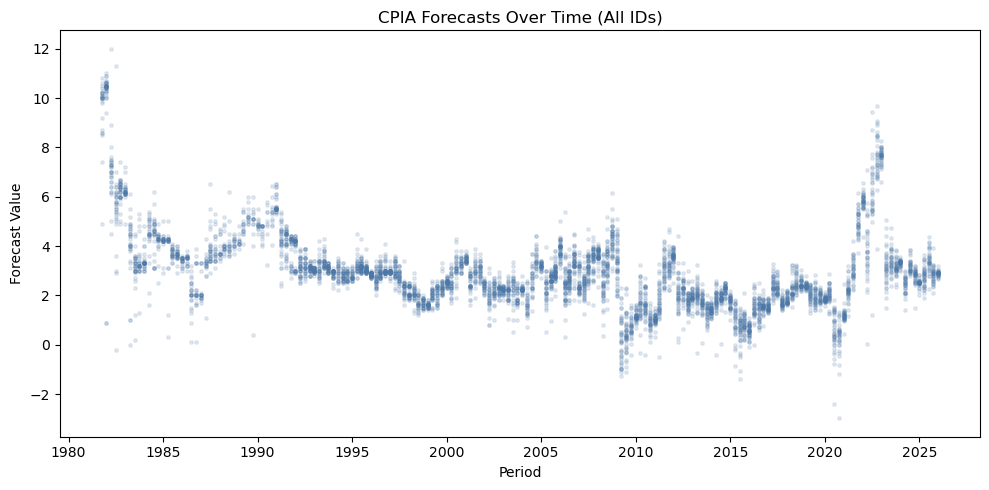

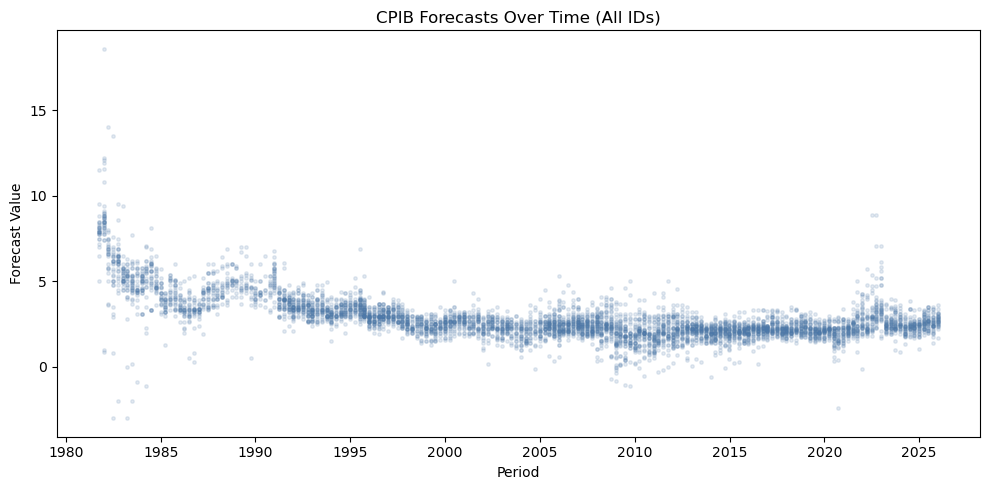

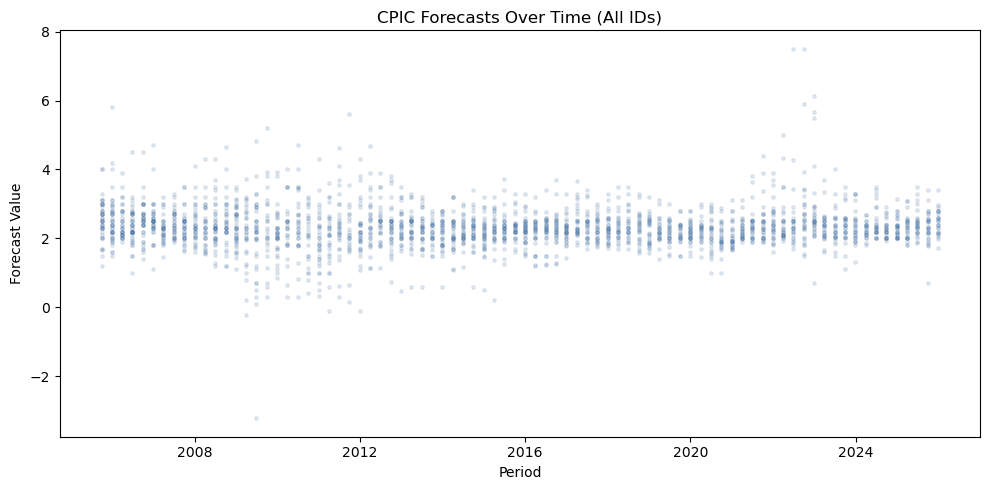

In [58]:
# Dispersion scatter: separate figures for each horizon
long = df.melt(id_vars=["ID", "period"], value_vars=forecast_cols,
               var_name="horizon", value_name="forecast")
long = long.dropna(subset=["forecast"])

for horizon, sub in long.groupby("horizon"):
    plt.figure(figsize=(10, 5))
    plt.scatter(sub["period"], sub["forecast"], s=6, alpha=0.15, color="#4C78A8")
    plt.title(f"{horizon} Forecasts Over Time (All IDs)")
    plt.xlabel("Period")
    plt.ylabel("Forecast Value")
    plt.tight_layout()
    plt.show()


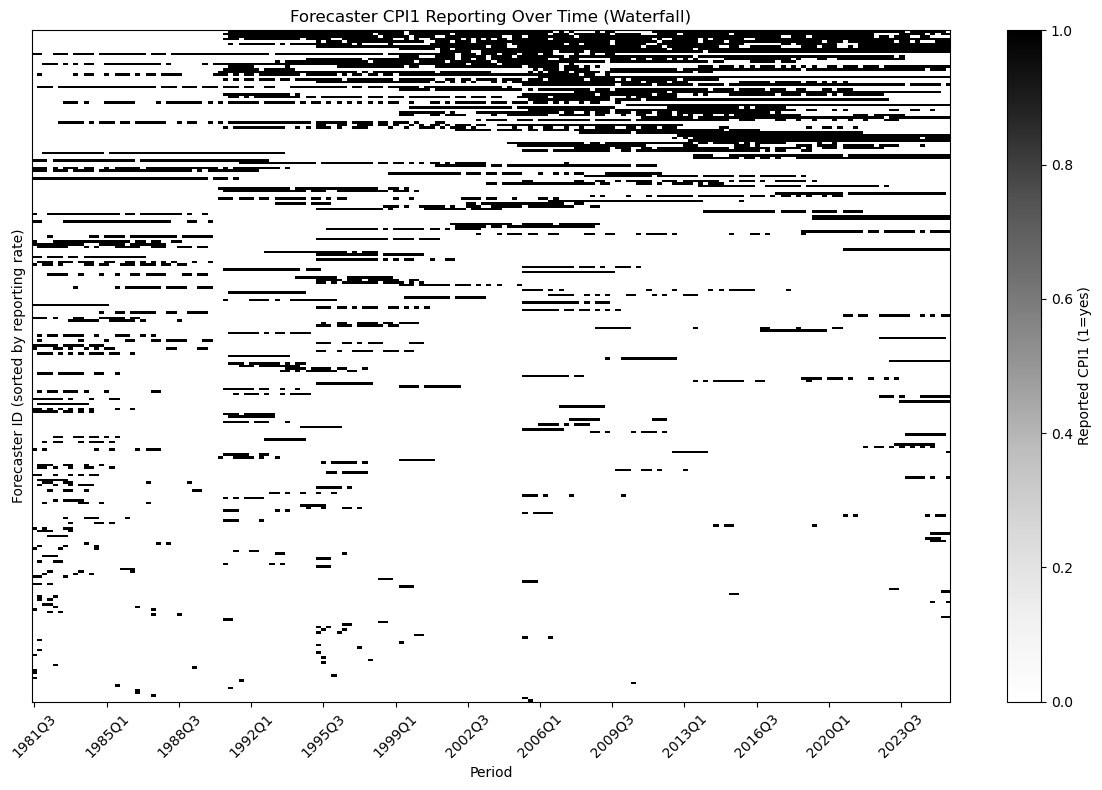

In [56]:
# Waterfall-style plot: forecaster reporting over time (ID x period), per horizon
for h in forecast_cols:
    report_matrix = (
        df.assign(reported=df[h].notna())
          .pivot_table(index="ID", columns="period", values="reported", aggfunc="max")
          .fillna(0)
    )

    # Sort forecasters by overall reporting rate (most consistent at top)
    report_matrix = report_matrix.loc[report_matrix.mean(axis=1).sort_values(ascending=False).index]

    # Prepare labels
    period_labels = report_matrix.columns.to_period('Q').astype(str)

    plt.figure(figsize=(12, 8))
    plt.imshow(report_matrix.to_numpy(dtype=float), aspect="auto", interpolation="nearest", cmap="Greys")
    plt.colorbar(label=f"Reported {h} (1=yes)")
    plt.title(f"Forecaster Reporting Over Time (Waterfall, {h})")
    plt.xlabel("Period")
    plt.ylabel("Forecaster ID (sorted by reporting rate)")

    # Show a subset of x-ticks for readability
    if report_matrix.shape[1] > 12:
        step = max(1, report_matrix.shape[1] // 12)
        xticks = list(range(0, report_matrix.shape[1], step))
        plt.xticks(xticks, [period_labels[i] for i in xticks], rotation=45)
    else:
        plt.xticks(range(report_matrix.shape[1]), period_labels, rotation=45)

    plt.yticks([])
    plt.tight_layout()
    plt.show()
